## Week 11 Homework (9)

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it
4. Describe how to use this to create arbitrary multivariate GLM regressions

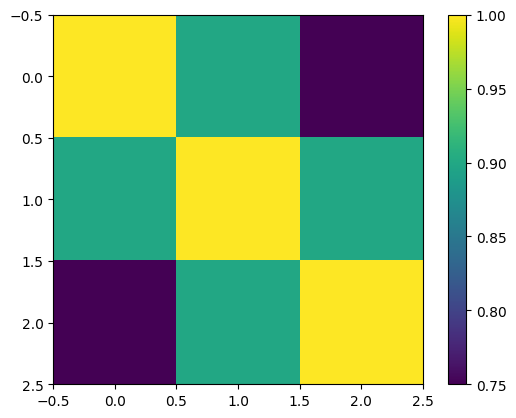

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


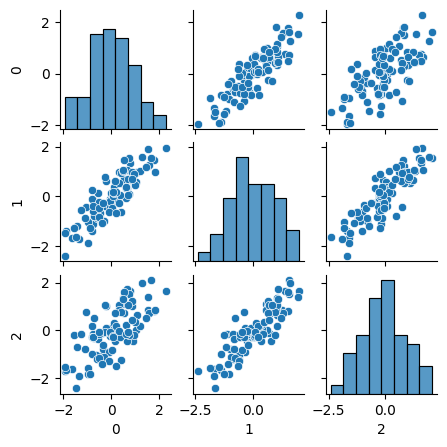

In [4]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

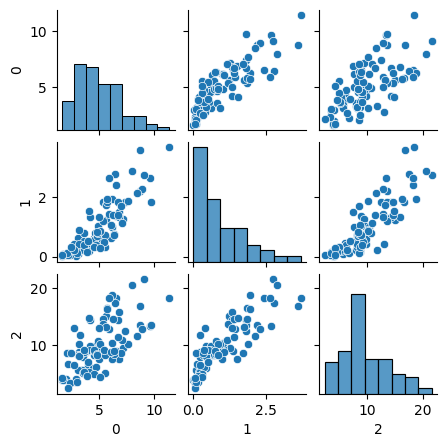

In [5]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [6]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_',
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, inv_beta=1)),
                           mu=0, sigma=1))

    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_',
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)),
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_',
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)),
                           mu=0, sigma=1))

    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=3),
                                 compute_corr=True)

    potential = pm.Potential("MVNeval",
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))

    idata = pm.sample()

# This probally produces a lot of warnings but it will run and provide inference


TypeError: Gamma.logcdf() got an unexpected keyword argument 'inv_beta'

In [ ]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

In [ ]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')

In [8]:
with pm.Model() as marg_gamma:
    alpha = pm.HalfNormal('alpha', sigma=10)
    y0 = pm.Gamma('y0', alpha=alpha, beta=1, observed=y[:, 0])
    idata_gamma = pm.sample()

with pm.Model() as marg_expon:
    lam = pm.HalfNormal('lam', sigma=10)
    y1 = pm.Exponential('y1', lam=lam, observed=y[:, 1])
    idata_expon = pm.sample()

with pm.Model() as marg_chi2:
    df_ = pm.HalfNormal('df_', sigma=10)
    y2 = pm.ChiSquared('y2', nu=df_, observed=y[:, 2])
    idata_chi2 = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [df_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [16]:
from scipy.stats import gamma, expon, chi2, norm

# Step 1: get posterior means
alpha_post = idata_gamma.posterior['alpha'].mean().item()
lam_post = idata_expon.posterior['lam'].mean().item()
df_post = idata_chi2.posterior['df_'].mean().item()

# Step 2: compute transformed variables
z0 = norm.ppf(gamma(a=alpha_post).cdf(y[:, 0]))
z1 = norm.ppf(expon(scale=1/lam_post).cdf(y[:, 1]))
z2 = norm.ppf(chi2(df=df_post).cdf(y[:, 2]))

z = np.column_stack([z0, z1, z2])

with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov('R', n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(lam=1.0),
                                   compute_corr=True)

    mvn = pm.MvNormal('z', mu=np.zeros(3), chol=L, observed=z)
    idata_copula = pm.sample(cores=1)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R]


Output()

/Users/cherylzhang/Desktop/fourth-year/winter/sta365/.venv/lib/python3.13/site-packages/pytensor/tensor/subtensor.p
y:2585: RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


/Users/cherylzhang/Desktop/fourth-year/winter/sta365/.venv/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


ValueError: Too many bins for data range. Cannot create 512 finite-sized bins.

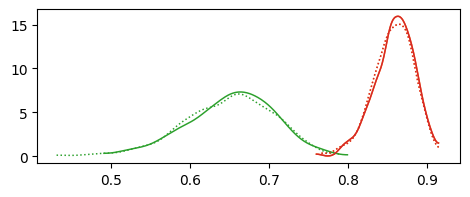

In [20]:
az.plot_trace(idata_copula, var_names=["R_corr"]);


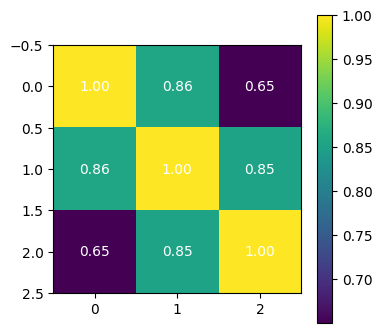

In [18]:
fig, ax = plt.subplots(1, figsize=(4, 4))
mean_corr = idata_copula.posterior["R_corr"].mean(dim=["chain", "draw"]).values
im = ax.imshow(mean_corr)
plt.colorbar(im, ax=ax)
for i in range(3):
    for j in range(3):
        ax.text(j, i, f"{mean_corr[i, j]:.2f}", ha='center', va='center', color='w')


A copula is a function that connects univariate marginal distributions to form a multivariate distribution. It lets us model dependency structure like correlation and the shape of joint behavior separately from the marginals.

In the one-pass implementation, we first fit the marginals and dependence together in one PyMC model and transformed each variable into standard normal form. And then we combine them into a multivariate normal using MvNormal and pm.Potential().

In the two-pass approach, we first fit each marginal distribution separately (Gamma, Exponential, Chi2) and use the CDF of each to transform to standard normal. Then we separately model the joint dependency on the transformed variables.

It's good to use this to create arbitrary multivariate GLM regressions because copula has the flexibility to mix and match marginal models and dependency structures, even when normality doesn't apply. This is because copula fits separate GLMs for each response (Gamma, Poisson) and use a copula to capture how their residuals or latent representations are correlated.



### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



In [21]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 100   # number of observations
p = 10    # number of predictors
m = 2     # number of output variables

X = np.random.normal(0, 1, size=(n, p))

# True beta: sparse
true_betas = np.zeros((p, m))
true_betas[1, 0] = 3.0
true_betas[4, 1] = -2.5

Y = X @ true_betas + np.random.normal(0, 1, size=(n, m))


In [22]:
import pymc as pm

with pm.Model() as spike_slab_model:
    z = pm.Bernoulli('z', p=0.5, shape=(p, m))  # variable inclusion indicator

    # Spike = 0, Slab = Normal
    slab_sd = 3.0
    beta = pm.Normal('beta', mu=0, sigma=slab_sd, shape=(p, m))
    w = pm.Deterministic('w', beta * z)

    sigma = pm.Exponential('sigma', 1.0, shape=m)

    mu = pm.math.dot(X, w)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)

    idata_slab = pm.sample(1000, tune=1000, target_accept=0.9, cores=1)


Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [z]
>NUTS: [beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
/Users/cherylzhang/Desktop/fourth-year/winter/sta365/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [23]:
with pm.Model() as normal_model:
    beta = pm.Normal('beta', mu=0, sigma=10.0, shape=(p, m))  # wide prior = diffuse
    sigma = pm.Exponential('sigma', 1.0, shape=m)

    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)

    idata_normal = pm.sample(1000, tune=1000, target_accept=0.9, cores=1)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


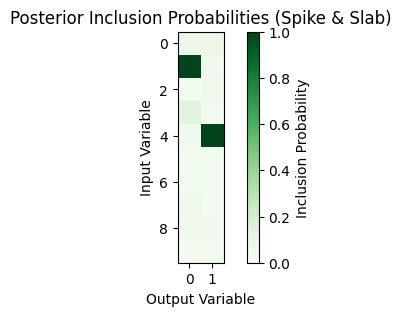

In [24]:
import matplotlib.pyplot as plt
import arviz as az

# Plot the posterior probability of z = 1 (inclusion)
z_mean = idata_slab.posterior['z'].mean(dim=["chain", "draw"]).values

fig, ax = plt.subplots(figsize=(6, 3))
im = ax.imshow(z_mean, cmap="Greens", vmin=0, vmax=1)
fig.colorbar(im, ax=ax, label="Inclusion Probability")
ax.set_title("Posterior Inclusion Probabilities (Spike & Slab)")
ax.set_xlabel("Output Variable")
ax.set_ylabel("Input Variable")
plt.show()


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

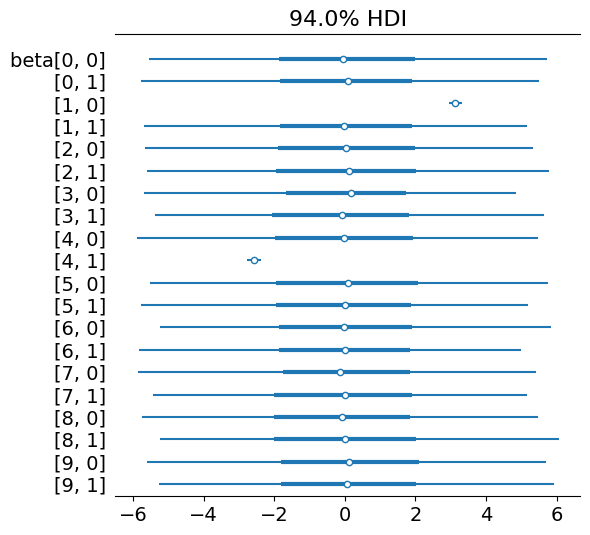

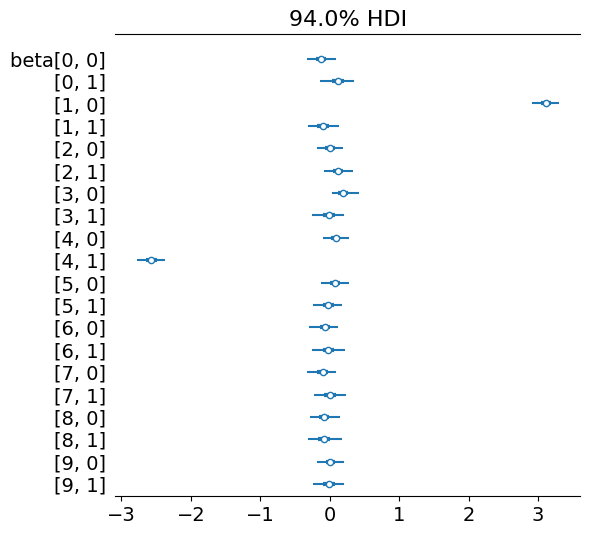

In [25]:
az.plot_forest(idata_slab, var_names=["beta"], combined=True)
az.plot_forest(idata_normal, var_names=["beta"], combined=True)


The data was simulated with 10 predictors and 2 response variables, but only 2 true non-zero coefficients. The spike and slab model was able to confidently select the correct variables (as shown by high inclusion probabilities), while pushing irrelevant coefficients toward zero. This resulted in a sparse, interpretable model. In contrast, the diffuse normal prior failed to enforce sparsity, and gave non-zero estimates to many irrelevant predictors — leading to unnecessary complexity. This illustrates the value of spike and slab priors for automatic variable selection in settings where true effects are sparse.

I used a small dataset with ($n=100$, $p=10$, $m=2$) to reduce computation demands. I noticed that increasing $n$ scales linearly and improves estimation, increasing $p$ slows down the sampler, especially with spike and slab, which introduces binary variables, and increasing $m$ adds parameter blocks and matrix ops, increasing cost moderately.

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



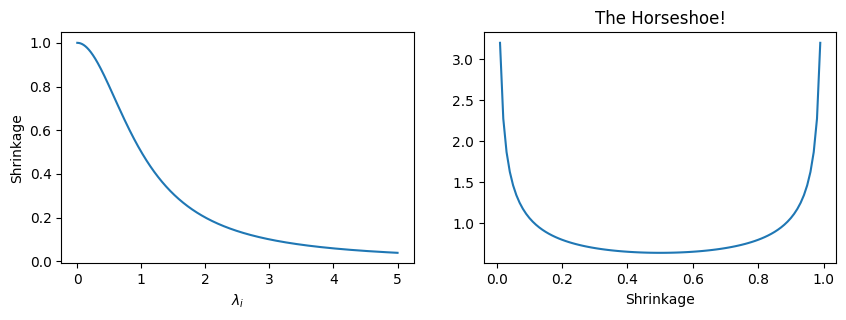

In [26]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
# change of variables:
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage,
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) *
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

In [27]:
with pm.Model() as horseshoe_model:
    # Global shrinkage parameter
    tau = pm.HalfCauchy("tau", beta=1.0)

    # Local shrinkage parameters (one per coefficient)
    lam = pm.HalfCauchy("lam", beta=1.0, shape=(p, m))

    # Final prior stddev for each coefficient
    sigma_w = pm.Deterministic("sigma_w", tau * lam)

    beta = pm.Normal("beta", mu=0, sigma=sigma_w, shape=(p, m))

    sigma = pm.Exponential("sigma", 1.0, shape=m)
    mu = pm.math.dot(X, beta)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y)

    idata_hs = pm.sample(1000, tune=1000, target_accept=0.9, cores=1)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, lam, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
There were 595 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

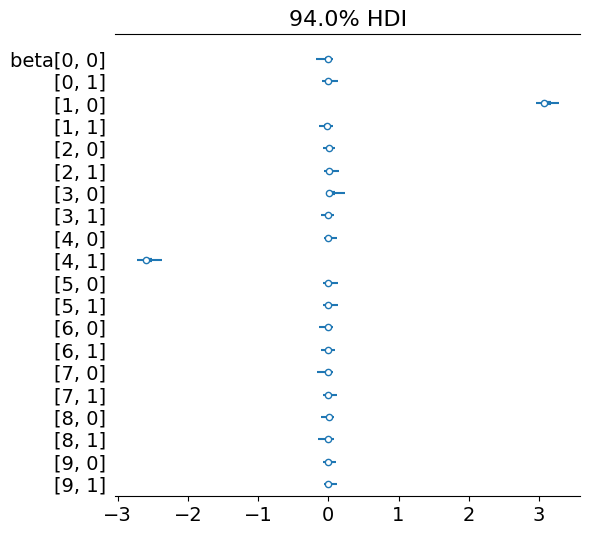

In [28]:
az.plot_forest(idata_hs, var_names=["beta"], combined=True)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

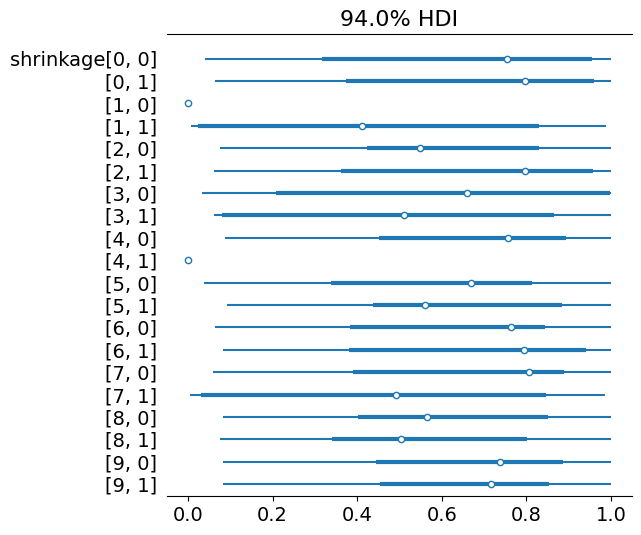

In [29]:
shrinkage_strength = 1 / (1 + idata_hs.posterior["lam"]**2)
az.plot_forest({"shrinkage": shrinkage_strength}, combined=True)


In both the Spike & Slab and Horseshoe models, the same key variables — specifically β[1, 0] and β[4, 1] — were identified as important. The Spike and Slab model made sharper decisions (clear binary selection via z), while the Horseshoe model shrank irrelevant coefficients continuously toward zero. The posterior shrinkage plot confirms this, showing high shrinkage on irrelevant variables and low shrinkage on true signal variables.